In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(337576, 828)
(337576, 1)
validation
(56520, 828)
(56520, 1)
test
(26800, 828)
(26800, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/34 [..............................] - ETA: 49s - loss: 0.1531 - STD: 1.2517e-04 - MAE: 0.3771

 4/34 [==>...........................] - ETA: 0s - loss: 0.0535 - STD: 4.0463e-04 - MAE: 0.1788 

 5/34 [===>..........................] - ETA: 1s - loss: 0.0474 - STD: 3.6493e-04 - MAE: 0.1660

 6/34 [====>.........................] - ETA: 1s - loss: 0.0439 - STD: 3.2514e-04 - MAE: 0.1598

 7/34 [=====>........................] - ETA: 1s - loss: 0.0419 - STD: 2.9049e-04 - MAE: 0.1567

 8/34 [======>.......................] - ETA: 1s - loss: 0.0405 - STD: 2.6098e-04 - MAE: 0.1546

 9/34 [======>.......................] - ETA: 1s - loss: 0.0394 - STD: 2.3612e-04 - MAE: 0.1532

10/34 [=======>......................] - ETA: 1s - loss: 0.0385 - STD: 2.1501e-04 - MAE: 0.1519

11/34 [========>.....................] - ETA: 1s - loss: 0.0377 - STD: 1.9706e-04 - MAE: 0.1505

12/34 [=========>....................] - ETA: 1s - loss: 0.0369 - STD: 1.8180e-04 - MAE: 0.1490

13/34 [==========>...................] - ETA: 1s - loss: 0.0361 - STD: 1.6887e-04 - MAE: 0.1473

14/34 [===========>..................] - ETA: 1s - loss: 0.0352 - STD: 1.5793e-04 - MAE: 0.1453

15/34 [============>.................] - ETA: 1s - loss: 0.0343 - STD: 1.4863e-04 - MAE: 0.1431

16/34 [=============>................] - ETA: 1s - loss: 0.0334 - STD: 1.4068e-04 - MAE: 0.1406

17/34 [==============>...............] - ETA: 0s - loss: 0.0325 - STD: 1.3386e-04 - MAE: 0.1379

18/34 [==============>...............] - ETA: 0s - loss: 0.0315 - STD: 1.2795e-04 - MAE: 0.1351

19/34 [===============>..............] - ETA: 0s - loss: 0.0305 - STD: 1.2279e-04 - MAE: 0.1324

20/34 [================>.............] - ETA: 0s - loss: 0.0296 - STD: 1.1822e-04 - MAE: 0.1298

21/34 [=================>............] - ETA: 0s - loss: 0.0287 - STD: 1.1414e-04 - MAE: 0.1276

22/34 [==================>...........] - ETA: 0s - loss: 0.0280 - STD: 1.1042e-04 - MAE: 0.1257

23/34 [===================>..........] - ETA: 0s - loss: 0.0273 - STD: 1.0700e-04 - MAE: 0.1242

24/34 [====================>.........] - ETA: 0s - loss: 0.0267 - STD: 1.0380e-04 - MAE: 0.1231

25/34 [=====================>........] - ETA: 0s - loss: 0.0262 - STD: 1.0083e-04 - MAE: 0.1222

26/34 [=====================>........] - ETA: 0s - loss: 0.0257 - STD: 9.8018e-05 - MAE: 0.1215

27/34 [======================>.......] - ETA: 0s - loss: 0.0253 - STD: 9.5368e-05 - MAE: 0.1208

28/34 [=======================>......] - ETA: 0s - loss: 0.0249 - STD: 9.2853e-05 - MAE: 0.1201

29/34 [========================>.....] - ETA: 0s - loss: 0.0245 - STD: 9.0506e-05 - MAE: 0.1193

30/34 [=========================>....] - ETA: 0s - loss: 0.0242 - STD: 8.8321e-05 - MAE: 0.1184

33/34 [============================>.] - ETA: 0s - loss: 0.0230 - STD: 8.2712e-05 - MAE: 0.1155

34/34 [==============================] - 5s 106ms/step - loss: 0.0227 - STD: 8.1111e-05 - MAE: 0.1145 - val_loss: 0.0147 - val_STD: 2.5047e-05 - val_MAE: 0.0920


Epoch 2/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0113 - STD: 2.8695e-05 - MAE: 0.0808

 2/34 [>.............................] - ETA: 2s - loss: 0.0113 - STD: 2.9317e-05 - MAE: 0.0805

 3/34 [=>............................] - ETA: 2s - loss: 0.0116 - STD: 2.9551e-05 - MAE: 0.0808

 4/34 [==>...........................] - ETA: 2s - loss: 0.0118 - STD: 2.9811e-05 - MAE: 0.0810

 5/34 [===>..........................] - ETA: 2s - loss: 0.0119 - STD: 3.0170e-05 - MAE: 0.0810

 6/34 [====>.........................] - ETA: 1s - loss: 0.0119 - STD: 3.0436e-05 - MAE: 0.0810

 7/34 [=====>........................] - ETA: 1s - loss: 0.0119 - STD: 3.0724e-05 - MAE: 0.0810

 8/34 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 3.1040e-05 - MAE: 0.0812

 9/34 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 3.1361e-05 - MAE: 0.0812

10/34 [=======>......................] - ETA: 1s - loss: 0.0119 - STD: 3.1707e-05 - MAE: 0.0812

11/34 [========>.....................] - ETA: 1s - loss: 0.0119 - STD: 3.2058e-05 - MAE: 0.0813

12/34 [=========>....................] - ETA: 1s - loss: 0.0118 - STD: 3.2409e-05 - MAE: 0.0813

13/34 [==========>...................] - ETA: 1s - loss: 0.0118 - STD: 3.2813e-05 - MAE: 0.0815

14/34 [===========>..................] - ETA: 1s - loss: 0.0117 - STD: 3.3205e-05 - MAE: 0.0817

15/34 [============>.................] - ETA: 1s - loss: 0.0117 - STD: 3.3594e-05 - MAE: 0.0819

16/34 [=============>................] - ETA: 1s - loss: 0.0117 - STD: 3.3980e-05 - MAE: 0.0821

17/34 [==============>...............] - ETA: 1s - loss: 0.0117 - STD: 3.4380e-05 - MAE: 0.0823

18/34 [==============>...............] - ETA: 1s - loss: 0.0117 - STD: 3.4772e-05 - MAE: 0.0826

19/34 [===============>..............] - ETA: 0s - loss: 0.0117 - STD: 3.5179e-05 - MAE: 0.0828

20/34 [================>.............] - ETA: 0s - loss: 0.0117 - STD: 3.5560e-05 - MAE: 0.0829

21/34 [=================>............] - ETA: 0s - loss: 0.0117 - STD: 3.5951e-05 - MAE: 0.0831

22/34 [==================>...........] - ETA: 0s - loss: 0.0117 - STD: 3.6346e-05 - MAE: 0.0832

23/34 [===================>..........] - ETA: 0s - loss: 0.0117 - STD: 3.6745e-05 - MAE: 0.0833

24/34 [====================>.........] - ETA: 0s - loss: 0.0116 - STD: 3.7147e-05 - MAE: 0.0833

25/34 [=====================>........] - ETA: 0s - loss: 0.0116 - STD: 3.7531e-05 - MAE: 0.0833

26/34 [=====================>........] - ETA: 0s - loss: 0.0116 - STD: 3.7913e-05 - MAE: 0.0833

27/34 [======================>.......] - ETA: 0s - loss: 0.0116 - STD: 3.8316e-05 - MAE: 0.0833

28/34 [=======================>......] - ETA: 0s - loss: 0.0116 - STD: 3.8703e-05 - MAE: 0.0832

29/34 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 3.9088e-05 - MAE: 0.0832

30/34 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 3.9484e-05 - MAE: 0.0832

31/34 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 3.9890e-05 - MAE: 0.0831

32/34 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 4.0304e-05 - MAE: 0.0831

33/34 [============================>.] - ETA: 0s - loss: 0.0116 - STD: 4.0704e-05 - MAE: 0.0831

34/34 [==============================] - ETA: 0s - loss: 0.0116 - STD: 4.1122e-05 - MAE: 0.0831

34/34 [==============================] - 2s 71ms/step - loss: 0.0116 - STD: 4.1122e-05 - MAE: 0.0831 - val_loss: 0.0140 - val_STD: 4.8527e-05 - val_MAE: 0.0912


Epoch 3/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0115 - STD: 5.6505e-05 - MAE: 0.0831

 2/34 [>.............................] - ETA: 2s - loss: 0.0115 - STD: 5.7058e-05 - MAE: 0.0837

 3/34 [=>............................] - ETA: 2s - loss: 0.0114 - STD: 5.7590e-05 - MAE: 0.0834

 4/34 [==>...........................] - ETA: 2s - loss: 0.0114 - STD: 5.8377e-05 - MAE: 0.0834

 5/34 [===>..........................] - ETA: 1s - loss: 0.0114 - STD: 5.8947e-05 - MAE: 0.0835

 6/34 [====>.........................] - ETA: 1s - loss: 0.0114 - STD: 5.9462e-05 - MAE: 0.0836

 7/34 [=====>........................] - ETA: 1s - loss: 0.0114 - STD: 6.0012e-05 - MAE: 0.0835

 8/34 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 6.0679e-05 - MAE: 0.0835

 9/34 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 6.1315e-05 - MAE: 0.0834

10/34 [=======>......................] - ETA: 1s - loss: 0.0113 - STD: 6.1963e-05 - MAE: 0.0835

11/34 [========>.....................] - ETA: 1s - loss: 0.0113 - STD: 6.2614e-05 - MAE: 0.0835

12/34 [=========>....................] - ETA: 1s - loss: 0.0113 - STD: 6.3258e-05 - MAE: 0.0836

13/34 [==========>...................] - ETA: 1s - loss: 0.0114 - STD: 6.3900e-05 - MAE: 0.0836

14/34 [===========>..................] - ETA: 1s - loss: 0.0114 - STD: 6.4536e-05 - MAE: 0.0836

15/34 [============>.................] - ETA: 1s - loss: 0.0114 - STD: 6.5176e-05 - MAE: 0.0835

16/34 [=============>................] - ETA: 1s - loss: 0.0114 - STD: 6.5784e-05 - MAE: 0.0835

17/34 [==============>...............] - ETA: 1s - loss: 0.0114 - STD: 6.6436e-05 - MAE: 0.0835

18/34 [==============>...............] - ETA: 1s - loss: 0.0114 - STD: 6.7141e-05 - MAE: 0.0835

20/34 [================>.............] - ETA: 0s - loss: 0.0114 - STD: 6.8467e-05 - MAE: 0.0834

21/34 [=================>............] - ETA: 0s - loss: 0.0114 - STD: 6.9171e-05 - MAE: 0.0834

22/34 [==================>...........] - ETA: 0s - loss: 0.0114 - STD: 6.9906e-05 - MAE: 0.0834

23/34 [===================>..........] - ETA: 0s - loss: 0.0114 - STD: 7.0620e-05 - MAE: 0.0834

24/34 [====================>.........] - ETA: 0s - loss: 0.0114 - STD: 7.1382e-05 - MAE: 0.0834

25/34 [=====================>........] - ETA: 0s - loss: 0.0114 - STD: 7.2172e-05 - MAE: 0.0834

26/34 [=====================>........] - ETA: 0s - loss: 0.0114 - STD: 7.2963e-05 - MAE: 0.0833

27/34 [======================>.......] - ETA: 0s - loss: 0.0114 - STD: 7.3775e-05 - MAE: 0.0833

28/34 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 7.4588e-05 - MAE: 0.0833

29/34 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 7.5450e-05 - MAE: 0.0834

30/34 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 7.6277e-05 - MAE: 0.0834

31/34 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 7.7132e-05 - MAE: 0.0833

32/34 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 7.8051e-05 - MAE: 0.0833

33/34 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 7.8966e-05 - MAE: 0.0833

34/34 [==============================] - ETA: 0s - loss: 0.0113 - STD: 7.9886e-05 - MAE: 0.0833

34/34 [==============================] - 2s 70ms/step - loss: 0.0113 - STD: 7.9886e-05 - MAE: 0.0833 - val_loss: 0.0139 - val_STD: 9.6611e-05 - val_MAE: 0.0912


Epoch 4/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0114 - STD: 1.1286e-04 - MAE: 0.0835

 2/34 [>.............................] - ETA: 2s - loss: 0.0112 - STD: 1.1386e-04 - MAE: 0.0830

 3/34 [=>............................] - ETA: 2s - loss: 0.0114 - STD: 1.1492e-04 - MAE: 0.0833

 4/34 [==>...........................] - ETA: 1s - loss: 0.0114 - STD: 1.1610e-04 - MAE: 0.0832

 5/34 [===>..........................] - ETA: 1s - loss: 0.0113 - STD: 1.1763e-04 - MAE: 0.0831

 6/34 [====>.........................] - ETA: 1s - loss: 0.0113 - STD: 1.1884e-04 - MAE: 0.0830

 7/34 [=====>........................] - ETA: 1s - loss: 0.0113 - STD: 1.2024e-04 - MAE: 0.0831

 8/34 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 1.2158e-04 - MAE: 0.0831

 9/34 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 1.2325e-04 - MAE: 0.0831

10/34 [=======>......................] - ETA: 1s - loss: 0.0113 - STD: 1.2470e-04 - MAE: 0.0830

11/34 [========>.....................] - ETA: 1s - loss: 0.0113 - STD: 1.2622e-04 - MAE: 0.0829

12/34 [=========>....................] - ETA: 1s - loss: 0.0113 - STD: 1.2759e-04 - MAE: 0.0829

13/34 [==========>...................] - ETA: 1s - loss: 0.0113 - STD: 1.2922e-04 - MAE: 0.0829

14/34 [===========>..................] - ETA: 1s - loss: 0.0113 - STD: 1.3081e-04 - MAE: 0.0829

15/34 [============>.................] - ETA: 1s - loss: 0.0113 - STD: 1.3248e-04 - MAE: 0.0830

16/34 [=============>................] - ETA: 1s - loss: 0.0113 - STD: 1.3416e-04 - MAE: 0.0830

17/34 [==============>...............] - ETA: 1s - loss: 0.0113 - STD: 1.3595e-04 - MAE: 0.0830

18/34 [==============>...............] - ETA: 1s - loss: 0.0113 - STD: 1.3766e-04 - MAE: 0.0831

19/34 [===============>..............] - ETA: 1s - loss: 0.0113 - STD: 1.3944e-04 - MAE: 0.0831

20/34 [================>.............] - ETA: 0s - loss: 0.0113 - STD: 1.4118e-04 - MAE: 0.0831

21/34 [=================>............] - ETA: 0s - loss: 0.0113 - STD: 1.4310e-04 - MAE: 0.0832

22/34 [==================>...........] - ETA: 0s - loss: 0.0113 - STD: 1.4506e-04 - MAE: 0.0832

23/34 [===================>..........] - ETA: 0s - loss: 0.0113 - STD: 1.4702e-04 - MAE: 0.0832

24/34 [====================>.........] - ETA: 0s - loss: 0.0113 - STD: 1.4905e-04 - MAE: 0.0832

25/34 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 1.5111e-04 - MAE: 0.0831

26/34 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 1.5324e-04 - MAE: 0.0832

27/34 [======================>.......] - ETA: 0s - loss: 0.0113 - STD: 1.5539e-04 - MAE: 0.0832

28/34 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 1.5772e-04 - MAE: 0.0832

29/34 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 1.6004e-04 - MAE: 0.0832

30/34 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 1.6240e-04 - MAE: 0.0832

31/34 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 1.6476e-04 - MAE: 0.0832

32/34 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 1.6725e-04 - MAE: 0.0832

33/34 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 1.6968e-04 - MAE: 0.0832

34/34 [==============================] - 2s 71ms/step - loss: 0.0113 - STD: 1.7226e-04 - MAE: 0.0831 - val_loss: 0.0139 - val_STD: 2.2662e-04 - val_MAE: 0.0911


Epoch 5/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0116 - STD: 2.6452e-04 - MAE: 0.0839

 2/34 [>.............................] - ETA: 2s - loss: 0.0115 - STD: 2.6963e-04 - MAE: 0.0839

 3/34 [=>............................] - ETA: 2s - loss: 0.0114 - STD: 2.7397e-04 - MAE: 0.0835

 4/34 [==>...........................] - ETA: 2s - loss: 0.0113 - STD: 2.7844e-04 - MAE: 0.0833

 5/34 [===>..........................] - ETA: 1s - loss: 0.0114 - STD: 2.8287e-04 - MAE: 0.0834

 6/34 [====>.........................] - ETA: 1s - loss: 0.0113 - STD: 2.8767e-04 - MAE: 0.0833

 7/34 [=====>........................] - ETA: 1s - loss: 0.0113 - STD: 2.9225e-04 - MAE: 0.0832

 8/34 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 2.9727e-04 - MAE: 0.0833

 9/34 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 3.0191e-04 - MAE: 0.0832

10/34 [=======>......................] - ETA: 1s - loss: 0.0113 - STD: 3.0682e-04 - MAE: 0.0831

11/34 [========>.....................] - ETA: 1s - loss: 0.0113 - STD: 3.1205e-04 - MAE: 0.0832

12/34 [=========>....................] - ETA: 1s - loss: 0.0113 - STD: 3.1731e-04 - MAE: 0.0832

13/34 [==========>...................] - ETA: 1s - loss: 0.0113 - STD: 3.2279e-04 - MAE: 0.0832

14/34 [===========>..................] - ETA: 1s - loss: 0.0113 - STD: 3.2835e-04 - MAE: 0.0833

15/34 [============>.................] - ETA: 1s - loss: 0.0113 - STD: 3.3404e-04 - MAE: 0.0833

16/34 [=============>................] - ETA: 1s - loss: 0.0113 - STD: 3.4005e-04 - MAE: 0.0833

17/34 [==============>...............] - ETA: 1s - loss: 0.0113 - STD: 3.4627e-04 - MAE: 0.0833

18/34 [==============>...............] - ETA: 1s - loss: 0.0113 - STD: 3.5257e-04 - MAE: 0.0833

19/34 [===============>..............] - ETA: 0s - loss: 0.0113 - STD: 3.5910e-04 - MAE: 0.0832

20/34 [================>.............] - ETA: 0s - loss: 0.0113 - STD: 3.6567e-04 - MAE: 0.0832

21/34 [=================>............] - ETA: 0s - loss: 0.0113 - STD: 3.7267e-04 - MAE: 0.0832

22/34 [==================>...........] - ETA: 0s - loss: 0.0113 - STD: 3.7966e-04 - MAE: 0.0831

23/34 [===================>..........] - ETA: 0s - loss: 0.0113 - STD: 3.8699e-04 - MAE: 0.0831

24/34 [====================>.........] - ETA: 0s - loss: 0.0113 - STD: 3.9472e-04 - MAE: 0.0831

25/34 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 4.0258e-04 - MAE: 0.0831

26/34 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 4.1087e-04 - MAE: 0.0831

27/34 [======================>.......] - ETA: 0s - loss: 0.0113 - STD: 4.1946e-04 - MAE: 0.0831

28/34 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 4.2857e-04 - MAE: 0.0831

29/34 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 4.3796e-04 - MAE: 0.0831

30/34 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 4.4753e-04 - MAE: 0.0830

31/34 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 4.5750e-04 - MAE: 0.0831

32/34 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 4.6774e-04 - MAE: 0.0830

34/34 [==============================] - ETA: 0s - loss: 0.0113 - STD: 4.8962e-04 - MAE: 0.0831

34/34 [==============================] - 2s 70ms/step - loss: 0.0113 - STD: 4.8962e-04 - MAE: 0.0831 - val_loss: 0.0137 - val_STD: 7.5163e-04 - val_MAE: 0.0909


Epoch 6/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0114 - STD: 8.9387e-04 - MAE: 0.0839

 2/34 [>.............................] - ETA: 2s - loss: 0.0113 - STD: 9.1440e-04 - MAE: 0.0836

 3/34 [=>............................] - ETA: 2s - loss: 0.0113 - STD: 9.3319e-04 - MAE: 0.0833

 4/34 [==>...........................] - ETA: 2s - loss: 0.0113 - STD: 9.5508e-04 - MAE: 0.0833

 5/34 [===>..........................] - ETA: 1s - loss: 0.0113 - STD: 9.7595e-04 - MAE: 0.0834

 6/34 [====>.........................] - ETA: 1s - loss: 0.0112 - STD: 9.9724e-04 - MAE: 0.0831

 7/34 [=====>........................] - ETA: 1s - loss: 0.0113 - STD: 0.0010 - MAE: 0.0830    

 8/34 [======>.......................] - ETA: 1s - loss: 0.0112 - STD: 0.0010 - MAE: 0.0829

 9/34 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0830

10/34 [=======>......................] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0831

11/34 [========>.....................] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0830

12/34 [=========>....................] - ETA: 1s - loss: 0.0112 - STD: 0.0012 - MAE: 0.0829

13/34 [==========>...................] - ETA: 1s - loss: 0.0112 - STD: 0.0012 - MAE: 0.0829

14/34 [===========>..................] - ETA: 1s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0829

15/34 [============>.................] - ETA: 1s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0830

16/34 [=============>................] - ETA: 1s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0829

18/34 [==============>...............] - ETA: 1s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0829

19/34 [===============>..............] - ETA: 0s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0829

20/34 [================>.............] - ETA: 0s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0829

21/34 [=================>............] - ETA: 0s - loss: 0.0112 - STD: 0.0015 - MAE: 0.0829

22/34 [==================>...........] - ETA: 0s - loss: 0.0112 - STD: 0.0015 - MAE: 0.0829

23/34 [===================>..........] - ETA: 0s - loss: 0.0112 - STD: 0.0016 - MAE: 0.0828

24/34 [====================>.........] - ETA: 0s - loss: 0.0112 - STD: 0.0016 - MAE: 0.0828

25/34 [=====================>........] - ETA: 0s - loss: 0.0112 - STD: 0.0017 - MAE: 0.0827

26/34 [=====================>........] - ETA: 0s - loss: 0.0112 - STD: 0.0017 - MAE: 0.0827

27/34 [======================>.......] - ETA: 0s - loss: 0.0112 - STD: 0.0018 - MAE: 0.0827

28/34 [=======================>......] - ETA: 0s - loss: 0.0112 - STD: 0.0018 - MAE: 0.0827

29/34 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 0.0019 - MAE: 0.0826

30/34 [=========================>....] - ETA: 0s - loss: 0.0112 - STD: 0.0020 - MAE: 0.0826

31/34 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 0.0020 - MAE: 0.0826

32/34 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0021 - MAE: 0.0826

33/34 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 0.0022 - MAE: 0.0826

34/34 [==============================] - ETA: 0s - loss: 0.0111 - STD: 0.0022 - MAE: 0.0825

34/34 [==============================] - 2s 71ms/step - loss: 0.0111 - STD: 0.0022 - MAE: 0.0825 - val_loss: 0.0134 - val_STD: 0.0042 - val_MAE: 0.0898


Epoch 7/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0112 - STD: 0.0050 - MAE: 0.0822

 2/34 [>.............................] - ETA: 2s - loss: 0.0111 - STD: 0.0052 - MAE: 0.0824

 3/34 [=>............................] - ETA: 2s - loss: 0.0109 - STD: 0.0053 - MAE: 0.0820

 5/34 [===>..........................] - ETA: 1s - loss: 0.0109 - STD: 0.0057 - MAE: 0.0821

 6/34 [====>.........................] - ETA: 1s - loss: 0.0109 - STD: 0.0058 - MAE: 0.0821

 7/34 [=====>........................] - ETA: 1s - loss: 0.0109 - STD: 0.0060 - MAE: 0.0818

 8/34 [======>.......................] - ETA: 1s - loss: 0.0108 - STD: 0.0062 - MAE: 0.0816

 9/34 [======>.......................] - ETA: 1s - loss: 0.0108 - STD: 0.0064 - MAE: 0.0815

10/34 [=======>......................] - ETA: 1s - loss: 0.0108 - STD: 0.0066 - MAE: 0.0814

11/34 [========>.....................] - ETA: 1s - loss: 0.0108 - STD: 0.0068 - MAE: 0.0814

12/34 [=========>....................] - ETA: 1s - loss: 0.0107 - STD: 0.0070 - MAE: 0.0812

13/34 [==========>...................] - ETA: 1s - loss: 0.0107 - STD: 0.0073 - MAE: 0.0812

14/34 [===========>..................] - ETA: 1s - loss: 0.0107 - STD: 0.0075 - MAE: 0.0811

15/34 [============>.................] - ETA: 1s - loss: 0.0107 - STD: 0.0078 - MAE: 0.0810

16/34 [=============>................] - ETA: 1s - loss: 0.0107 - STD: 0.0080 - MAE: 0.0809

17/34 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.0083 - MAE: 0.0809

18/34 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.0086 - MAE: 0.0808

19/34 [===============>..............] - ETA: 0s - loss: 0.0106 - STD: 0.0088 - MAE: 0.0807

20/34 [================>.............] - ETA: 0s - loss: 0.0106 - STD: 0.0091 - MAE: 0.0806

21/34 [=================>............] - ETA: 0s - loss: 0.0105 - STD: 0.0095 - MAE: 0.0806

22/34 [==================>...........] - ETA: 0s - loss: 0.0105 - STD: 0.0098 - MAE: 0.0805

23/34 [===================>..........] - ETA: 0s - loss: 0.0105 - STD: 0.0101 - MAE: 0.0803

24/34 [====================>.........] - ETA: 0s - loss: 0.0105 - STD: 0.0105 - MAE: 0.0802

25/34 [=====================>........] - ETA: 0s - loss: 0.0104 - STD: 0.0108 - MAE: 0.0801

26/34 [=====================>........] - ETA: 0s - loss: 0.0104 - STD: 0.0112 - MAE: 0.0801

27/34 [======================>.......] - ETA: 0s - loss: 0.0104 - STD: 0.0116 - MAE: 0.0800

28/34 [=======================>......] - ETA: 0s - loss: 0.0104 - STD: 0.0120 - MAE: 0.0799

29/34 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 0.0124 - MAE: 0.0797

30/34 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 0.0128 - MAE: 0.0796

31/34 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.0132 - MAE: 0.0795

32/34 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 0.0136 - MAE: 0.0794

33/34 [============================>.] - ETA: 0s - loss: 0.0102 - STD: 0.0141 - MAE: 0.0793

34/34 [==============================] - ETA: 0s - loss: 0.0102 - STD: 0.0145 - MAE: 0.0792

34/34 [==============================] - 2s 72ms/step - loss: 0.0102 - STD: 0.0145 - MAE: 0.0792 - val_loss: 0.0118 - val_STD: 0.0257 - val_MAE: 0.0843


Epoch 8/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0096 - STD: 0.0304 - MAE: 0.0770

 2/34 [>.............................] - ETA: 2s - loss: 0.0094 - STD: 0.0309 - MAE: 0.0760

 3/34 [=>............................] - ETA: 1s - loss: 0.0093 - STD: 0.0314 - MAE: 0.0759

 4/34 [==>...........................] - ETA: 1s - loss: 0.0092 - STD: 0.0320 - MAE: 0.0756

 5/34 [===>..........................] - ETA: 1s - loss: 0.0092 - STD: 0.0326 - MAE: 0.0753

 6/34 [====>.........................] - ETA: 1s - loss: 0.0092 - STD: 0.0331 - MAE: 0.0750

 7/34 [=====>........................] - ETA: 1s - loss: 0.0091 - STD: 0.0336 - MAE: 0.0748

 9/34 [======>.......................] - ETA: 1s - loss: 0.0091 - STD: 0.0346 - MAE: 0.0745

10/34 [=======>......................] - ETA: 1s - loss: 0.0091 - STD: 0.0351 - MAE: 0.0745

11/34 [========>.....................] - ETA: 1s - loss: 0.0090 - STD: 0.0355 - MAE: 0.0744

12/34 [=========>....................] - ETA: 1s - loss: 0.0090 - STD: 0.0359 - MAE: 0.0742

13/34 [==========>...................] - ETA: 1s - loss: 0.0090 - STD: 0.0363 - MAE: 0.0741

14/34 [===========>..................] - ETA: 1s - loss: 0.0090 - STD: 0.0367 - MAE: 0.0740

15/34 [============>.................] - ETA: 1s - loss: 0.0089 - STD: 0.0370 - MAE: 0.0739

16/34 [=============>................] - ETA: 1s - loss: 0.0089 - STD: 0.0373 - MAE: 0.0737

17/34 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.0376 - MAE: 0.0737

18/34 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.0379 - MAE: 0.0736

19/34 [===============>..............] - ETA: 0s - loss: 0.0089 - STD: 0.0382 - MAE: 0.0735

20/34 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.0385 - MAE: 0.0734

21/34 [=================>............] - ETA: 0s - loss: 0.0088 - STD: 0.0388 - MAE: 0.0733

22/34 [==================>...........] - ETA: 0s - loss: 0.0088 - STD: 0.0391 - MAE: 0.0733

23/34 [===================>..........] - ETA: 0s - loss: 0.0088 - STD: 0.0393 - MAE: 0.0732

24/34 [====================>.........] - ETA: 0s - loss: 0.0088 - STD: 0.0396 - MAE: 0.0731

25/34 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0398 - MAE: 0.0730

26/34 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0401 - MAE: 0.0729

27/34 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0403 - MAE: 0.0728

28/34 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.0405 - MAE: 0.0726

29/34 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0407 - MAE: 0.0725

30/34 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0409 - MAE: 0.0724

31/34 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0412 - MAE: 0.0724

32/34 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0414 - MAE: 0.0723

33/34 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0416 - MAE: 0.0721

34/34 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0418 - MAE: 0.0720

34/34 [==============================] - 2s 69ms/step - loss: 0.0086 - STD: 0.0418 - MAE: 0.0720 - val_loss: 0.0119 - val_STD: 0.0470 - val_MAE: 0.0868


Epoch 9/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.0510 - MAE: 0.0689

 2/34 [>.............................] - ETA: 2s - loss: 0.0077 - STD: 0.0508 - MAE: 0.0687

 3/34 [=>............................] - ETA: 2s - loss: 0.0077 - STD: 0.0505 - MAE: 0.0683

 4/34 [==>...........................] - ETA: 1s - loss: 0.0076 - STD: 0.0507 - MAE: 0.0681

 6/34 [====>.........................] - ETA: 1s - loss: 0.0076 - STD: 0.0512 - MAE: 0.0678

 7/34 [=====>........................] - ETA: 1s - loss: 0.0076 - STD: 0.0513 - MAE: 0.0677

 8/34 [======>.......................] - ETA: 1s - loss: 0.0076 - STD: 0.0517 - MAE: 0.0677

 9/34 [======>.......................] - ETA: 1s - loss: 0.0076 - STD: 0.0520 - MAE: 0.0676

10/34 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.0523 - MAE: 0.0675

11/34 [========>.....................] - ETA: 1s - loss: 0.0075 - STD: 0.0525 - MAE: 0.0673

12/34 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.0527 - MAE: 0.0671

13/34 [==========>...................] - ETA: 1s - loss: 0.0075 - STD: 0.0529 - MAE: 0.0671

14/34 [===========>..................] - ETA: 1s - loss: 0.0075 - STD: 0.0532 - MAE: 0.0670

15/34 [============>.................] - ETA: 1s - loss: 0.0075 - STD: 0.0535 - MAE: 0.0670

16/34 [=============>................] - ETA: 1s - loss: 0.0075 - STD: 0.0536 - MAE: 0.0669

17/34 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0538 - MAE: 0.0669

18/34 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0540 - MAE: 0.0668

19/34 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.0542 - MAE: 0.0667

20/34 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0545 - MAE: 0.0666

21/34 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.0546 - MAE: 0.0665

22/34 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0548 - MAE: 0.0664

23/34 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.0551 - MAE: 0.0663

24/34 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0553 - MAE: 0.0662

25/34 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0555 - MAE: 0.0662

26/34 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0557 - MAE: 0.0661

27/34 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0559 - MAE: 0.0660

28/34 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0562 - MAE: 0.0660

29/34 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0564 - MAE: 0.0659

30/34 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0566 - MAE: 0.0658

31/34 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0568 - MAE: 0.0657

32/34 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0570 - MAE: 0.0657

33/34 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0571 - MAE: 0.0656

34/34 [==============================] - ETA: 0s - loss: 0.0072 - STD: 0.0573 - MAE: 0.0655

34/34 [==============================] - 2s 72ms/step - loss: 0.0072 - STD: 0.0573 - MAE: 0.0655 - val_loss: 0.0114 - val_STD: 0.0646 - val_MAE: 0.0847


Epoch 10/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0069 - STD: 0.0652 - MAE: 0.0641

 2/34 [>.............................] - ETA: 2s - loss: 0.0067 - STD: 0.0630 - MAE: 0.0628

 4/34 [==>...........................] - ETA: 1s - loss: 0.0069 - STD: 0.0644 - MAE: 0.0637

 5/34 [===>..........................] - ETA: 1s - loss: 0.0069 - STD: 0.0635 - MAE: 0.0634

 6/34 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.0633 - MAE: 0.0631

 7/34 [=====>........................] - ETA: 1s - loss: 0.0069 - STD: 0.0639 - MAE: 0.0636

 8/34 [======>.......................] - ETA: 1s - loss: 0.0069 - STD: 0.0635 - MAE: 0.0634

 9/34 [======>.......................] - ETA: 1s - loss: 0.0069 - STD: 0.0632 - MAE: 0.0633

10/34 [=======>......................] - ETA: 1s - loss: 0.0069 - STD: 0.0636 - MAE: 0.0634

11/34 [========>.....................] - ETA: 1s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0633

12/34 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.0634 - MAE: 0.0631

13/34 [==========>...................] - ETA: 1s - loss: 0.0068 - STD: 0.0634 - MAE: 0.0631

14/34 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0637 - MAE: 0.0631

15/34 [============>.................] - ETA: 1s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0631

16/34 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0635 - MAE: 0.0630

17/34 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0637 - MAE: 0.0630

18/34 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0638 - MAE: 0.0630

19/34 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0637 - MAE: 0.0630

20/34 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0639 - MAE: 0.0629

21/34 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0640 - MAE: 0.0629

22/34 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0639 - MAE: 0.0628

23/34 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0640 - MAE: 0.0628

24/34 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0641 - MAE: 0.0628

25/34 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0642 - MAE: 0.0628

26/34 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0641 - MAE: 0.0627

27/34 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0642 - MAE: 0.0627

28/34 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0643 - MAE: 0.0627

29/34 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0643 - MAE: 0.0626

30/34 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0643 - MAE: 0.0626

31/34 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0644 - MAE: 0.0625

32/34 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0645 - MAE: 0.0625

33/34 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0645 - MAE: 0.0624

34/34 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0646 - MAE: 0.0623

34/34 [==============================] - 2s 72ms/step - loss: 0.0066 - STD: 0.0646 - MAE: 0.0623 - val_loss: 0.0111 - val_STD: 0.0680 - val_MAE: 0.0827


Epoch 11/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0680 - MAE: 0.0617

 2/34 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0678 - MAE: 0.0614

 4/34 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0675 - MAE: 0.0611

 5/34 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0613

 7/34 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0669 - MAE: 0.0610

 8/34 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0671 - MAE: 0.0610

 9/34 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0611

10/34 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0611

11/34 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0611

12/34 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0671 - MAE: 0.0611

13/34 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0669 - MAE: 0.0610

14/34 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0609

15/34 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0610

16/34 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0610

17/34 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0609

18/34 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0669 - MAE: 0.0609

19/34 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0669 - MAE: 0.0609

20/34 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0669 - MAE: 0.0609

21/34 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0609

22/34 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0609

23/34 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0671 - MAE: 0.0608

24/34 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0672 - MAE: 0.0608

25/34 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0672 - MAE: 0.0608

26/34 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0671 - MAE: 0.0607

27/34 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0608

28/34 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0608

29/34 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0672 - MAE: 0.0607

30/34 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0674 - MAE: 0.0608

31/34 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0608

32/34 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0672 - MAE: 0.0607

33/34 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0674 - MAE: 0.0608

34/34 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0608

34/34 [==============================] - 2s 63ms/step - loss: 0.0064 - STD: 0.0673 - MAE: 0.0608 - val_loss: 0.0109 - val_STD: 0.0654 - val_MAE: 0.0810


Epoch 12/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0647 - MAE: 0.0587

 2/34 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0600

 3/34 [=>............................] - ETA: 1s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0602

 4/34 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0599

 5/34 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0680 - MAE: 0.0600

 6/34 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0687 - MAE: 0.0603

 7/34 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0682 - MAE: 0.0601

 8/34 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0678 - MAE: 0.0600

 9/34 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0682 - MAE: 0.0603

10/34 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0682 - MAE: 0.0603

11/34 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0678 - MAE: 0.0602

12/34 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0679 - MAE: 0.0602

13/34 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0601

14/34 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0680 - MAE: 0.0601

15/34 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0600

16/34 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0601

17/34 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0600

18/34 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0600

19/34 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0600

20/34 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0600

21/34 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0599

22/34 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0599

23/34 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0600

24/34 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0599

26/34 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0599

27/34 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0599

28/34 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0598

29/34 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0598

30/34 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0599

31/34 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0598

32/34 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0598

33/34 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0598

34/34 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0598

34/34 [==============================] - 2s 63ms/step - loss: 0.0062 - STD: 0.0690 - MAE: 0.0598 - val_loss: 0.0109 - val_STD: 0.0689 - val_MAE: 0.0807


Epoch 13/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0590

 2/34 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0586

 3/34 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0701 - MAE: 0.0592

 4/34 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0700 - MAE: 0.0589

 5/34 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0586

 6/34 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0587

 7/34 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0588

 8/34 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0587

10/34 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0588

11/34 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0590

12/34 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

13/34 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0589

14/34 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0590

15/34 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0590

16/34 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0589

17/34 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0707 - MAE: 0.0590

18/34 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0590

19/34 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0589

20/34 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0590

21/34 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0590

22/34 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

23/34 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0589

24/34 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0707 - MAE: 0.0589

25/34 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

26/34 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

27/34 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0590

28/34 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

29/34 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0588

30/34 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

31/34 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

32/34 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

33/34 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0590

34/34 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0590

34/34 [==============================] - 2s 63ms/step - loss: 0.0061 - STD: 0.0706 - MAE: 0.0590 - val_loss: 0.0109 - val_STD: 0.0678 - val_MAE: 0.0800


Epoch 14/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0660 - MAE: 0.0581

 2/34 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0583

 3/34 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0591

 4/34 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0587

 5/34 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0585

 6/34 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0588

 7/34 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0585

 8/34 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0584

 9/34 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0586

11/34 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0708 - MAE: 0.0584

12/34 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0712 - MAE: 0.0585

13/34 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0714 - MAE: 0.0586

14/34 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0712 - MAE: 0.0584

15/34 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0713 - MAE: 0.0584

16/34 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0715 - MAE: 0.0586

17/34 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0712 - MAE: 0.0586

18/34 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0585

19/34 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0713 - MAE: 0.0587

20/34 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

21/34 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0586

22/34 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

23/34 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

24/34 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0709 - MAE: 0.0587

25/34 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0587

26/34 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

27/34 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0587

28/34 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0709 - MAE: 0.0586

29/34 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

30/34 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0587

31/34 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0709 - MAE: 0.0586

32/34 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

33/34 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

34/34 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0586

34/34 [==============================] - 2s 64ms/step - loss: 0.0060 - STD: 0.0710 - MAE: 0.0586 - val_loss: 0.0106 - val_STD: 0.0738 - val_MAE: 0.0801


Epoch 15/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0735 - MAE: 0.0595

 2/34 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0751 - MAE: 0.0600

 3/34 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0730 - MAE: 0.0591

 4/34 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0726 - MAE: 0.0586

 6/34 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0728 - MAE: 0.0588

 7/34 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0724 - MAE: 0.0585

 8/34 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0585

 9/34 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0584

10/34 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0582

11/34 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0582

12/34 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0581

13/34 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0581

14/34 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0580

15/34 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0579

16/34 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0580

17/34 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0580

18/34 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0580

19/34 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0729 - MAE: 0.0580

20/34 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0729 - MAE: 0.0580

21/34 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0579

22/34 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0579

23/34 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0579

24/34 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0579

25/34 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0578

26/34 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0578

27/34 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0578

28/34 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0578

29/34 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0578

30/34 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0578

31/34 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0578

32/34 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0577

33/34 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0578

34/34 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0577

34/34 [==============================] - 2s 62ms/step - loss: 0.0058 - STD: 0.0728 - MAE: 0.0577 - val_loss: 0.0104 - val_STD: 0.0727 - val_MAE: 0.0787


Epoch 16/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0725 - MAE: 0.0575

 2/34 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0576

 4/34 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0724 - MAE: 0.0572

 5/34 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0727 - MAE: 0.0574

 6/34 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0575

 7/34 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0730 - MAE: 0.0574

 8/34 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0731 - MAE: 0.0573

 9/34 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0736 - MAE: 0.0574

10/34 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0734 - MAE: 0.0572

11/34 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0734 - MAE: 0.0572

12/34 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0735 - MAE: 0.0573

13/34 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0734 - MAE: 0.0573

14/34 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0732 - MAE: 0.0572

15/34 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0733 - MAE: 0.0573

16/34 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0574

17/34 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0573

18/34 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0573

19/34 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0573

20/34 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0573

21/34 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

22/34 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

23/34 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

24/34 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

25/34 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0573

26/34 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0573

27/34 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0573

28/34 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0573

29/34 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0572

30/34 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0573

31/34 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0573

32/34 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0572

33/34 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0573

34/34 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0572

34/34 [==============================] - 2s 62ms/step - loss: 0.0058 - STD: 0.0733 - MAE: 0.0572 - val_loss: 0.0102 - val_STD: 0.0742 - val_MAE: 0.0782


Epoch 17/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0727 - MAE: 0.0574

 2/34 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0580

 3/34 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0573

 4/34 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0727 - MAE: 0.0572

 5/34 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0735 - MAE: 0.0572

 6/34 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0724 - MAE: 0.0569

 7/34 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0727 - MAE: 0.0570

 8/34 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0732 - MAE: 0.0574

 9/34 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0572

10/34 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0573

11/34 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0574

12/34 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0729 - MAE: 0.0573

13/34 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0574

14/34 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0574

15/34 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0574

16/34 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0575

17/34 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0575

18/34 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0575

19/34 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0575

20/34 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0575

21/34 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0574

22/34 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0574

23/34 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0575

24/34 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0574

25/34 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0573

26/34 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0575

27/34 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0575

28/34 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0574

29/34 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0576

30/34 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0575

32/34 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0576

33/34 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0575

34/34 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0575

34/34 [==============================] - 2s 63ms/step - loss: 0.0058 - STD: 0.0730 - MAE: 0.0575 - val_loss: 0.0103 - val_STD: 0.0762 - val_MAE: 0.0791


Epoch 18/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.0764 - MAE: 0.0589

 2/34 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0580

 3/34 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0729 - MAE: 0.0571

 4/34 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0733 - MAE: 0.0571

 5/34 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0739 - MAE: 0.0576

 6/34 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0736 - MAE: 0.0573

 7/34 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0732 - MAE: 0.0571

 8/34 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0736 - MAE: 0.0572

 9/34 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0735 - MAE: 0.0571

10/34 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0734 - MAE: 0.0570

11/34 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0735 - MAE: 0.0569

12/34 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0570

13/34 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0569

14/34 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0568

15/34 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0740 - MAE: 0.0568

16/34 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0740 - MAE: 0.0568

17/34 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0568

18/34 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0742 - MAE: 0.0568

19/34 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0567

20/34 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0741 - MAE: 0.0567

21/34 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0567

22/34 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0566

23/34 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0566

24/34 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0566

26/34 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0566

27/34 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0566

28/34 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0566

29/34 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0566

30/34 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0565

31/34 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0566

32/34 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0565

33/34 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0565

34/34 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0565

34/34 [==============================] - 2s 64ms/step - loss: 0.0056 - STD: 0.0744 - MAE: 0.0565 - val_loss: 0.0101 - val_STD: 0.0730 - val_MAE: 0.0768


Epoch 19/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0727 - MAE: 0.0555

 2/34 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0737 - MAE: 0.0554

 3/34 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0558

 4/34 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0556

 5/34 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0742 - MAE: 0.0555

 6/34 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0744 - MAE: 0.0558

 7/34 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0744 - MAE: 0.0558

 8/34 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0558

 9/34 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0558

10/34 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0558

11/34 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0560

12/34 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0559

13/34 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0558

14/34 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0560

15/34 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0559

16/34 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0559

17/34 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0560

18/34 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0559

19/34 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0559

20/34 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0754 - MAE: 0.0560

21/34 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0752 - MAE: 0.0560

22/34 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0752 - MAE: 0.0561

23/34 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0561

25/34 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0561

26/34 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0561

27/34 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0560

28/34 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0561

29/34 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0560

30/34 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0560

31/34 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0561

32/34 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0748 - MAE: 0.0561

33/34 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0748 - MAE: 0.0561

34/34 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0562

34/34 [==============================] - 2s 63ms/step - loss: 0.0056 - STD: 0.0749 - MAE: 0.0562 - val_loss: 0.0102 - val_STD: 0.0713 - val_MAE: 0.0766


Epoch 20/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0708 - MAE: 0.0555

 2/34 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0729 - MAE: 0.0557

 3/34 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0562

 4/34 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0739 - MAE: 0.0557

 5/34 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0744 - MAE: 0.0557

 6/34 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0751 - MAE: 0.0561

 7/34 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0559

 8/34 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0748 - MAE: 0.0560

 9/34 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0754 - MAE: 0.0563

10/34 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0561

11/34 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0561

12/34 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0752 - MAE: 0.0564

13/34 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0564

14/34 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0563

15/34 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0567

16/34 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0745 - MAE: 0.0567

17/34 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0566

18/34 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0748 - MAE: 0.0572

19/34 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0571

20/34 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0570

21/34 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0575

22/34 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0574

23/34 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0574

25/34 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0575

26/34 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0574

27/34 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0573

28/34 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

29/34 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0574

30/34 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0573

31/34 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0572

32/34 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

33/34 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0573

34/34 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0572

34/34 [==============================] - 2s 62ms/step - loss: 0.0058 - STD: 0.0733 - MAE: 0.0572 - val_loss: 0.0101 - val_STD: 0.0723 - val_MAE: 0.0770


Epoch 21/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0710 - MAE: 0.0554

 2/34 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0739 - MAE: 0.0571

 3/34 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0744 - MAE: 0.0563

 4/34 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0737 - MAE: 0.0561

 5/34 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0560

 6/34 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0747 - MAE: 0.0561

 7/34 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0559

 8/34 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0558

 9/34 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0558

10/34 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0558

11/34 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0556

12/34 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0555

13/34 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0557

14/34 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0557

15/34 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0556

16/34 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0556

17/34 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0557

18/34 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0557

19/34 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0557

20/34 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0558

21/34 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0558

22/34 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0557

23/34 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0557

24/34 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0557

25/34 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0556

26/34 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0556

27/34 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0556

28/34 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0556

29/34 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0556

30/34 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0556

31/34 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0556

32/34 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0555

33/34 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0555

34/34 [==============================] - 2s 63ms/step - loss: 0.0054 - STD: 0.0753 - MAE: 0.0555 - val_loss: 0.0098 - val_STD: 0.0750 - val_MAE: 0.0756


Epoch 22/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0548

 2/34 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0549

 3/34 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0751 - MAE: 0.0550

 4/34 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0551

 5/34 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0755 - MAE: 0.0550

 6/34 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0550

 7/34 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

 8/34 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0550

10/34 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

11/34 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

12/34 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0549

13/34 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

14/34 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

15/34 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

16/34 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

17/34 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0550

18/34 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0550

19/34 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0550

20/34 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0550

21/34 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0550

22/34 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0550

23/34 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0550

24/34 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

25/34 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0550

26/34 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

27/34 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

28/34 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

29/34 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

30/34 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0549

31/34 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

32/34 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

33/34 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0549

34/34 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0549

34/34 [==============================] - 2s 63ms/step - loss: 0.0053 - STD: 0.0763 - MAE: 0.0549 - val_loss: 0.0097 - val_STD: 0.0781 - val_MAE: 0.0757


Epoch 23/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0546

 2/34 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0543

 3/34 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0546

 4/34 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

 5/34 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0762 - MAE: 0.0548

 6/34 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0550

 7/34 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0551

 8/34 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0550

 9/34 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0550

10/34 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0549

11/34 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0548

12/34 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0549

13/34 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0549

14/34 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0548

15/34 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0549

17/34 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0548

18/34 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0549

19/34 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0549

20/34 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0549

21/34 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0548

22/34 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0548

23/34 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0549

24/34 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0548

25/34 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0549

26/34 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

27/34 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

28/34 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

29/34 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

30/34 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

31/34 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0547

32/34 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0547

33/34 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

34/34 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0548

34/34 [==============================] - 2s 64ms/step - loss: 0.0053 - STD: 0.0767 - MAE: 0.0548 - val_loss: 0.0097 - val_STD: 0.0773 - val_MAE: 0.0753


Epoch 24/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0546

 2/34 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0778 - MAE: 0.0549

 3/34 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0546

 4/34 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0772 - MAE: 0.0550

 5/34 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0547

 6/34 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0546

 7/34 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0547

 8/34 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0546

 9/34 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0546

10/34 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0545

11/34 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0544

12/34 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0545

13/34 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0544

14/34 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0544

15/34 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0545

16/34 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0545

17/34 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0546

18/34 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0546

19/34 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0545

20/34 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0546

21/34 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0546

23/34 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0547

24/34 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0546

25/34 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0547

26/34 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0546

27/34 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0546

28/34 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0546

29/34 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0546

30/34 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0546

31/34 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0546

32/34 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0545

33/34 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0545

34/34 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0545

34/34 [==============================] - 2s 63ms/step - loss: 0.0053 - STD: 0.0769 - MAE: 0.0545 - val_loss: 0.0097 - val_STD: 0.0785 - val_MAE: 0.0751


Epoch 25/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0790 - MAE: 0.0544

 2/34 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0790 - MAE: 0.0546

 3/34 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0775 - MAE: 0.0539

 4/34 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0775 - MAE: 0.0542

 6/34 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0539

 7/34 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0541

 8/34 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0540

 9/34 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0540

10/34 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0541

11/34 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0767 - MAE: 0.0541

12/34 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0542

13/34 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0542

14/34 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0768 - MAE: 0.0541

15/34 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0543

16/34 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0768 - MAE: 0.0543

17/34 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0545

18/34 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0544

19/34 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0769 - MAE: 0.0544

20/34 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0545

21/34 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0545

22/34 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0545

23/34 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0772 - MAE: 0.0545

24/34 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0545

25/34 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0772 - MAE: 0.0546

26/34 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0546

27/34 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0545

28/34 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0546

29/34 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0546

30/34 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0546

31/34 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0547

32/34 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

33/34 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0548

34/34 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0548

34/34 [==============================] - 2s 62ms/step - loss: 0.0053 - STD: 0.0769 - MAE: 0.0548 - val_loss: 0.0105 - val_STD: 0.0702 - val_MAE: 0.0761


Epoch 26/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0669 - MAE: 0.0559

 2/34 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0551

 3/34 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0755 - MAE: 0.0578

 4/34 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0730 - MAE: 0.0574

 5/34 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0567

 6/34 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0750 - MAE: 0.0590

 7/34 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0734 - MAE: 0.0587

 8/34 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0583

 9/34 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0730 - MAE: 0.0588

10/34 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0731 - MAE: 0.0587

11/34 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0722 - MAE: 0.0584

12/34 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0719 - MAE: 0.0581

14/34 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0725 - MAE: 0.0580

15/34 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0722 - MAE: 0.0578

16/34 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0723 - MAE: 0.0575

17/34 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0577

18/34 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0730 - MAE: 0.0575

19/34 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0574

20/34 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0572

21/34 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0573

22/34 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0572

23/34 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0570

24/34 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0568

25/34 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0734 - MAE: 0.0569

26/34 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0737 - MAE: 0.0568

27/34 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0736 - MAE: 0.0567

28/34 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0736 - MAE: 0.0566

29/34 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0565

30/34 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0565

31/34 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0564

32/34 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0741 - MAE: 0.0564

33/34 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0563

34/34 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0563

34/34 [==============================] - 2s 62ms/step - loss: 0.0056 - STD: 0.0743 - MAE: 0.0563 - val_loss: 0.0097 - val_STD: 0.0743 - val_MAE: 0.0747


Epoch 27/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0736 - MAE: 0.0535

 2/34 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0739 - MAE: 0.0533

 3/34 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0540

 4/34 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0537

 5/34 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0535

 6/34 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0536

 7/34 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0536

 8/34 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0537

 9/34 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0763 - MAE: 0.0537

10/34 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0763 - MAE: 0.0537

11/34 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0536

12/34 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0537

13/34 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0536

14/34 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0766 - MAE: 0.0536

15/34 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0536

16/34 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0536

17/34 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0536

18/34 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0769 - MAE: 0.0537

19/34 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0537

20/34 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0537

21/34 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0537

22/34 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0769 - MAE: 0.0537

23/34 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0537

24/34 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0537

25/34 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0770 - MAE: 0.0538

26/34 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0771 - MAE: 0.0538

27/34 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0770 - MAE: 0.0538

29/34 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0539

30/34 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0539

31/34 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0539

32/34 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0772 - MAE: 0.0539

33/34 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0772 - MAE: 0.0538

34/34 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0771 - MAE: 0.0538

34/34 [==============================] - 2s 64ms/step - loss: 0.0051 - STD: 0.0771 - MAE: 0.0538 - val_loss: 0.0095 - val_STD: 0.0797 - val_MAE: 0.0746


Epoch 28/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0545

 2/34 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0541

 3/34 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0777 - MAE: 0.0536

 4/34 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0777 - MAE: 0.0536

 5/34 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0536

 6/34 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0535

 7/34 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0777 - MAE: 0.0534

 8/34 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0535

 9/34 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0776 - MAE: 0.0535

10/34 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0776 - MAE: 0.0535

12/34 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0537

13/34 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0537

14/34 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0537

15/34 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0537

16/34 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0537

17/34 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0537

18/34 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0537

19/34 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0536

20/34 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0537

21/34 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0536

22/34 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0536

23/34 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0537

24/34 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0537

25/34 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0536

26/34 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0536

27/34 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0536

28/34 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0536

29/34 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0536

30/34 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0535

31/34 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0536

32/34 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0535

33/34 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0535

34/34 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0535

34/34 [==============================] - 2s 63ms/step - loss: 0.0051 - STD: 0.0782 - MAE: 0.0535 - val_loss: 0.0096 - val_STD: 0.0781 - val_MAE: 0.0738


Epoch 29/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0755 - MAE: 0.0536

 2/34 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0535

 3/34 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0534

 4/34 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0777 - MAE: 0.0533

 5/34 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0536

 6/34 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0535

 7/34 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0534

 8/34 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0534

 9/34 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0533

10/34 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0533

11/34 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0533

12/34 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0532

13/34 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0781 - MAE: 0.0532

14/34 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0533

15/34 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0533

16/34 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0533

17/34 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0532

18/34 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0532

19/34 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0532

20/34 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0532

21/34 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0532

22/34 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0532

23/34 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0531

24/34 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0531

25/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531

26/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531

27/34 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0531

28/34 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0531

29/34 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531

30/34 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0532

31/34 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0532

32/34 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0532

33/34 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0533

34/34 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0533

34/34 [==============================] - 2s 62ms/step - loss: 0.0051 - STD: 0.0784 - MAE: 0.0533 - val_loss: 0.0096 - val_STD: 0.0821 - val_MAE: 0.0751


Epoch 30/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0542

 2/34 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0811 - MAE: 0.0543

 3/34 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

 4/34 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0540

 5/34 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0541

 6/34 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0539

 7/34 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0783 - MAE: 0.0541

 8/34 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0540

 9/34 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0539

10/34 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0539

11/34 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0539

12/34 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0538

13/34 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0539

14/34 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0538

15/34 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0537

16/34 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0538

17/34 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0537

18/34 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0537

19/34 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0537

20/34 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0536

21/34 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0536

22/34 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0536

23/34 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0535

24/34 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0534

25/34 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0536

26/34 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0535

27/34 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0536

28/34 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0536

29/34 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0536

30/34 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0536

31/34 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0537

33/34 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0537

34/34 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0537

34/34 [==============================] - 2s 63ms/step - loss: 0.0051 - STD: 0.0783 - MAE: 0.0537 - val_loss: 0.0096 - val_STD: 0.0765 - val_MAE: 0.0734


Epoch 31/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0522

 2/34 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0769 - MAE: 0.0534

 3/34 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0533

 5/34 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0533

 6/34 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0779 - MAE: 0.0533

 7/34 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0777 - MAE: 0.0533

 8/34 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0534

 9/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0782 - MAE: 0.0533

10/34 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0782 - MAE: 0.0532

11/34 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0531

12/34 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0531

13/34 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0782 - MAE: 0.0531

14/34 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0532

15/34 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0532

16/34 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0531

17/34 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0532

18/34 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0532

19/34 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0532

20/34 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0532

21/34 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0532

22/34 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0531

23/34 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0532

25/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0531

26/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0532

27/34 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0531

28/34 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0531

29/34 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0531

30/34 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0531

31/34 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0531

32/34 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531

33/34 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531

34/34 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531

34/34 [==============================] - 2s 62ms/step - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531 - val_loss: 0.0096 - val_STD: 0.0825 - val_MAE: 0.0754


Epoch 32/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0818 - MAE: 0.0531

 2/34 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0528

 3/34 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0531

 4/34 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0533

 5/34 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0530

 6/34 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0529

 7/34 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0529

 8/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0530

 9/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0531

10/34 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0530

11/34 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0528

12/34 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0530

13/34 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0529

14/34 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0529

15/34 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0531

16/34 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0531

17/34 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0530

18/34 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0530

19/34 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0529

20/34 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0529

21/34 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0529

22/34 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0529

23/34 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

24/34 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0529

25/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

26/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0529

27/34 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

28/34 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0529

29/34 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

30/34 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

31/34 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0529

32/34 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0529

33/34 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

34/34 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

34/34 [==============================] - 2s 67ms/step - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529 - val_loss: 0.0095 - val_STD: 0.0787 - val_MAE: 0.0731


Epoch 33/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0524

 2/34 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0532

 3/34 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0780 - MAE: 0.0526

 4/34 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0778 - MAE: 0.0526

 5/34 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0531

 6/34 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0530

 7/34 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0529

 8/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0529

 9/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0529

10/34 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0528

11/34 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0527

12/34 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0527

13/34 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0526

14/34 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0526

15/34 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0528

16/34 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0527

17/34 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0528

18/34 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0529

20/34 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0529

21/34 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0528

22/34 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0528

23/34 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0528

24/34 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0528

25/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0529

26/34 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0528

27/34 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0528

28/34 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0528

29/34 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0528

30/34 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0528

31/34 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0528

32/34 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0527

33/34 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0527

34/34 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0527

34/34 [==============================] - 2s 66ms/step - loss: 0.0050 - STD: 0.0791 - MAE: 0.0527 - val_loss: 0.0094 - val_STD: 0.0825 - val_MAE: 0.0738


Epoch 34/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0521

 2/34 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0522

 3/34 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0519

 4/34 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0520

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0520

 6/34 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0520

 7/34 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0521

 8/34 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0521

 9/34 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0523

10/34 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0523

11/34 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

12/34 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0523

13/34 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0523

14/34 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0523

15/34 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

16/34 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

17/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0523

18/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

19/34 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524

20/34 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0524

21/34 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0524

22/34 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0524

23/34 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0524

25/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0524

26/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

27/34 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

28/34 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

29/34 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0524

30/34 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

31/34 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

32/34 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0524

33/34 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0524

34/34 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0524

34/34 [==============================] - 2s 71ms/step - loss: 0.0049 - STD: 0.0796 - MAE: 0.0524 - val_loss: 0.0094 - val_STD: 0.0807 - val_MAE: 0.0733


Epoch 35/10000


 1/34 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0778 - MAE: 0.0507

 2/34 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0786 - MAE: 0.0518

 3/34 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0520

 4/34 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0519

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0520

 7/34 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0517

 8/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0520

 9/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0519

10/34 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0519

11/34 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0519

12/34 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0518

13/34 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0519

14/34 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0520

15/34 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0522

16/34 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

17/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

18/34 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

19/34 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

20/34 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

21/34 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

22/34 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0521

23/34 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0522

24/34 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

25/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

26/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

27/34 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0521

28/34 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

29/34 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

30/34 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

31/34 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

32/34 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

33/34 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0522

34/34 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0522

34/34 [==============================] - 2s 70ms/step - loss: 0.0049 - STD: 0.0796 - MAE: 0.0522 - val_loss: 0.0094 - val_STD: 0.0840 - val_MAE: 0.0739


Epoch 36/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0518

 2/34 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

 3/34 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0521

 4/34 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0518

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0521

 6/34 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0519

 7/34 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0521

 8/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0520

 9/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0520

10/34 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0521

11/34 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0520

12/34 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0522

13/34 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0522

14/34 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0522

16/34 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0521

17/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

18/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0521

19/34 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0521

20/34 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0521

21/34 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0521

22/34 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0521

23/34 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0521

24/34 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0521

25/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0521

26/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0523

27/34 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

28/34 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524

29/34 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524

30/34 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

31/34 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524

32/34 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0524

33/34 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0524

34/34 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524

34/34 [==============================] - 2s 69ms/step - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524 - val_loss: 0.0098 - val_STD: 0.0779 - val_MAE: 0.0738


Epoch 37/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0742 - MAE: 0.0518

 2/34 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0785 - MAE: 0.0544

 3/34 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0778 - MAE: 0.0536

 4/34 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0777 - MAE: 0.0529

 5/34 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0532

 6/34 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0530

 7/34 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0529

 8/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0529

 9/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0786 - MAE: 0.0527

10/34 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0527

11/34 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0527

12/34 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0526

13/34 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0527

14/34 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0526

15/34 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0525

16/34 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0526

17/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0525

18/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0524

19/34 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0524

20/34 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0524

21/34 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

22/34 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0523

23/34 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0523

24/34 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0523

25/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0523

26/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0523

28/34 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0522

29/34 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

30/34 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

31/34 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

32/34 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

33/34 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

34/34 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522

34/34 [==============================] - 2s 70ms/step - loss: 0.0049 - STD: 0.0794 - MAE: 0.0522 - val_loss: 0.0094 - val_STD: 0.0842 - val_MAE: 0.0738


Epoch 38/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0800 - MAE: 0.0519

 2/34 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0521

 3/34 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0515

 4/34 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0521

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0519

 6/34 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0517

 7/34 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0519

 8/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0518

 9/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0519

10/34 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0519

11/34 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0518

12/34 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0519

13/34 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0518

14/34 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0518

15/34 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0518

16/34 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0518

17/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

18/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0518

19/34 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0519

20/34 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

21/34 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

22/34 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0519

23/34 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

24/34 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

25/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

26/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

27/34 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

28/34 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

29/34 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0518

30/34 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

31/34 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0519

32/34 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0519

33/34 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0519

34/34 [==============================] - 2s 71ms/step - loss: 0.0048 - STD: 0.0801 - MAE: 0.0519 - val_loss: 0.0094 - val_STD: 0.0828 - val_MAE: 0.0732


Epoch 39/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0513

 2/34 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0526

 3/34 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0518

 4/34 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0516

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0517

 6/34 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0515

 7/34 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0799 - MAE: 0.0516

 8/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0515

 9/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0516

10/34 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0515

11/34 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0517

12/34 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516

13/34 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0516

14/34 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

15/34 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0517

16/34 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0518

18/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0517

19/34 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

20/34 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0517

21/34 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0517

22/34 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0517

23/34 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0517

24/34 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0516

25/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0516

26/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0516

27/34 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0516

28/34 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0516

29/34 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516

30/34 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0516

31/34 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516

32/34 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0516

33/34 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516

34/34 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516

34/34 [==============================] - 2s 69ms/step - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516 - val_loss: 0.0094 - val_STD: 0.0828 - val_MAE: 0.0730


Epoch 40/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0783 - MAE: 0.0509

 2/34 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

 3/34 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0515

 4/34 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0522

 5/34 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0520

 6/34 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

 7/34 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0520

 8/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0518

 9/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0520

10/34 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0519

11/34 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0521

12/34 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0520

13/34 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0520

14/34 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0524

15/34 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

16/34 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

17/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0524

18/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0524

19/34 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0526

20/34 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0525

21/34 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0524

22/34 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524

23/34 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

25/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0524

26/34 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

27/34 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

28/34 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0524

29/34 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

30/34 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

31/34 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

32/34 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

33/34 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0523

34/34 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

34/34 [==============================] - 2s 70ms/step - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522 - val_loss: 0.0094 - val_STD: 0.0833 - val_MAE: 0.0736


Epoch 41/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0801 - MAE: 0.0506

 2/34 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0510

 3/34 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0510

 4/34 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0509

 5/34 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0509

 6/34 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0511

 7/34 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0511

 8/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0510

 9/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0801 - MAE: 0.0511

10/34 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0801 - MAE: 0.0510

12/34 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0511

13/34 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0511

14/34 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0511

15/34 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0512

16/34 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0802 - MAE: 0.0511

17/34 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0512

18/34 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0512

19/34 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0512

20/34 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0512

21/34 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0512

22/34 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0512

23/34 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

24/34 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0512

25/34 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0513

26/34 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0513

27/34 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0513

28/34 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

29/34 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

30/34 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

31/34 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

32/34 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

33/34 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

34/34 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0511

34/34 [==============================] - 2s 71ms/step - loss: 0.0047 - STD: 0.0806 - MAE: 0.0511 - val_loss: 0.0094 - val_STD: 0.0855 - val_MAE: 0.0738


Epoch 42/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0515

 2/34 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0512

 3/34 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0508

 4/34 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0508

 5/34 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0509

 6/34 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0508

 7/34 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0509

 8/34 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0508

 9/34 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0508

10/34 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0508

11/34 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0507

12/34 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0508

13/34 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0507

14/34 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0510

15/34 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0511

17/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0516

18/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0516

19/34 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0518

20/34 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

21/34 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0519

22/34 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

23/34 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

24/34 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

25/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0517

26/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

27/34 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

28/34 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

29/34 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

30/34 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

31/34 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

32/34 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0516

33/34 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

34/34 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

34/34 [==============================] - 2s 69ms/step - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517 - val_loss: 0.0094 - val_STD: 0.0847 - val_MAE: 0.0738


Epoch 43/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0510

 2/34 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0510

 3/34 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0520

 4/34 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0800 - MAE: 0.0513

 5/34 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0514

 6/34 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0516

 7/34 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0800 - MAE: 0.0514

 8/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0802 - MAE: 0.0514

 9/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0514

10/34 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0802 - MAE: 0.0513

11/34 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0802 - MAE: 0.0514

12/34 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0514

13/34 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0801 - MAE: 0.0513

14/34 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0514

15/34 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0514

17/34 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0514

18/34 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0513

19/34 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0513

20/34 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0514

21/34 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0514

22/34 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

23/34 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0514

24/34 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0514

25/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0515

26/34 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0514

27/34 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0514

28/34 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0514

29/34 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0514

30/34 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0513

31/34 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0513

32/34 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0513

33/34 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0514

34/34 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0513

34/34 [==============================] - 2s 71ms/step - loss: 0.0047 - STD: 0.0805 - MAE: 0.0513 - val_loss: 0.0093 - val_STD: 0.0844 - val_MAE: 0.0730


Epoch 44/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0806 - MAE: 0.0500

 2/34 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0822 - MAE: 0.0516

 3/34 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0513

 4/34 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0513

 5/34 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0513

 6/34 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0511

 7/34 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0512

 8/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0511

 9/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0511

10/34 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0512

11/34 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0511

12/34 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0510

13/34 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0510

14/34 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0510

15/34 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0510

16/34 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0509

17/34 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0509

18/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0508

19/34 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0508

20/34 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0508

21/34 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0508

22/34 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0508

23/34 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0508

24/34 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0508

25/34 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0507

26/34 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0509

27/34 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0509

28/34 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0511

29/34 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0510

31/34 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

32/34 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0510

33/34 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0512

34/34 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0512

34/34 [==============================] - 2s 71ms/step - loss: 0.0047 - STD: 0.0808 - MAE: 0.0512 - val_loss: 0.0095 - val_STD: 0.0839 - val_MAE: 0.0737


Epoch 45/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0498

 2/34 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0829 - MAE: 0.0523

 4/34 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0521

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0524

 6/34 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

 7/34 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

 8/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0521

 9/34 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0519

10/34 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0519

11/34 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0517

12/34 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0516

13/34 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

14/34 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

15/34 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

16/34 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0518

17/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

18/34 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

19/34 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

20/34 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0517

21/34 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0517

22/34 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

23/34 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516

24/34 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0516

25/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

26/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

27/34 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0517

28/34 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

29/34 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0519

30/34 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0518

31/34 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0521

32/34 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

33/34 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0520

34/34 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0523

34/34 [==============================] - 2s 71ms/step - loss: 0.0049 - STD: 0.0801 - MAE: 0.0523 - val_loss: 0.0099 - val_STD: 0.0776 - val_MAE: 0.0740


Epoch 46/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0717 - MAE: 0.0519

 2/34 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0721 - MAE: 0.0513

 3/34 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0543

 4/34 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0532

 5/34 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0530

 6/34 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0531

 7/34 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0530

 8/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0527

 9/34 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0525

10/34 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0527

11/34 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0784 - MAE: 0.0525

12/34 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0781 - MAE: 0.0524

13/34 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0785 - MAE: 0.0525

14/34 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0786 - MAE: 0.0524

15/34 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0784 - MAE: 0.0523

16/34 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0784 - MAE: 0.0522

17/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0788 - MAE: 0.0522

18/34 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0787 - MAE: 0.0521

20/34 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0788 - MAE: 0.0520

21/34 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0519

22/34 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0519

23/34 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0518

24/34 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0518

25/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0517

26/34 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0517

27/34 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0517

28/34 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0516

29/34 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0516

30/34 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0515

31/34 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0515

32/34 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0515

33/34 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0514

34/34 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0514

34/34 [==============================] - 2s 70ms/step - loss: 0.0047 - STD: 0.0796 - MAE: 0.0514 - val_loss: 0.0094 - val_STD: 0.0834 - val_MAE: 0.0736


Epoch 47/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0509

 2/34 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0503

 4/34 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0503

 5/34 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0502

 6/34 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0806 - MAE: 0.0502

 7/34 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0503

 8/34 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0503

 9/34 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0504

10/34 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0504

11/34 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0504

12/34 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0504

13/34 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0504

14/34 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0504

15/34 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0503

16/34 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0504

17/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0503

18/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0503

19/34 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0503

20/34 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0503

21/34 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0503

22/34 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0503

23/34 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0503

24/34 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0503

25/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0503

26/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0503

27/34 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0502

28/34 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0502

29/34 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0502

30/34 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0502

31/34 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0502

32/34 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0502

33/34 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0502

34/34 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0502

34/34 [==============================] - 2s 70ms/step - loss: 0.0045 - STD: 0.0815 - MAE: 0.0502 - val_loss: 0.0094 - val_STD: 0.0860 - val_MAE: 0.0734


Epoch 48/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0497

 2/34 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0500

 3/34 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0498

 4/34 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0499

 5/34 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499

 6/34 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0500

 7/34 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0501

 8/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0501

 9/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0502

10/34 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0501

11/34 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

12/34 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0501

14/34 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0502

15/34 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

16/34 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

17/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

18/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

19/34 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

20/34 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

21/34 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

22/34 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0501

23/34 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

24/34 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0500

25/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0500

26/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

27/34 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0501

28/34 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

29/34 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

30/34 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

31/34 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

32/34 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

33/34 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

34/34 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

34/34 [==============================] - 2s 71ms/step - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501 - val_loss: 0.0094 - val_STD: 0.0849 - val_MAE: 0.0733


Epoch 49/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0497

 2/34 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0503

 3/34 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0499

 4/34 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499

 5/34 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0498

 6/34 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0816 - MAE: 0.0500

 7/34 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0499

 8/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0499

 9/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0500

10/34 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0817 - MAE: 0.0499

11/34 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

13/34 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

14/34 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0500

15/34 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0499

16/34 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0499

17/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0499

18/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0499

19/34 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

20/34 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0500

21/34 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0501

22/34 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0501

23/34 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0501

24/34 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0501

25/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0501

26/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0503

27/34 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0503

28/34 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0503

29/34 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0503

30/34 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0502

31/34 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0503

32/34 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

33/34 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

34/34 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

34/34 [==============================] - 2s 69ms/step - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504 - val_loss: 0.0099 - val_STD: 0.0802 - val_MAE: 0.0737


Epoch 50/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0517

 2/34 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0808 - MAE: 0.0525

 3/34 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0515

 4/34 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0509

 5/34 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0514

 6/34 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0510

 7/34 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0509

 8/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0509

 9/34 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0508

10/34 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0508

11/34 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0507

12/34 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0505

13/34 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0504

14/34 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0505

15/34 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0505

16/34 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0505

17/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0814 - MAE: 0.0504

18/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0503

19/34 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0503

20/34 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0503

21/34 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0503

22/34 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0503

23/34 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0503

24/34 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0503

25/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0817 - MAE: 0.0502

26/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0502

27/34 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0816 - MAE: 0.0502

28/34 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0501

29/34 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0502

31/34 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0501

32/34 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0816 - MAE: 0.0501

33/34 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0501

34/34 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0816 - MAE: 0.0501

34/34 [==============================] - 2s 71ms/step - loss: 0.0045 - STD: 0.0816 - MAE: 0.0501 - val_loss: 0.0093 - val_STD: 0.0844 - val_MAE: 0.0728


Epoch 51/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0814 - MAE: 0.0496

 2/34 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

 3/34 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0497

 4/34 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0495

 5/34 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0830 - MAE: 0.0501

 6/34 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0500

 7/34 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0502

 9/34 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0500

10/34 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0502

11/34 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

12/34 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

13/34 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

14/34 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0501

15/34 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0502

16/34 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0502

17/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

18/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

19/34 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

20/34 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

21/34 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

22/34 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

23/34 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0501

24/34 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

25/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

26/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0500

27/34 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0500

28/34 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

29/34 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

30/34 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499

31/34 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0499

32/34 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0499

33/34 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0499

34/34 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0499

34/34 [==============================] - 2s 70ms/step - loss: 0.0045 - STD: 0.0821 - MAE: 0.0499 - val_loss: 0.0095 - val_STD: 0.0856 - val_MAE: 0.0742


Epoch 52/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0814 - MAE: 0.0497

 2/34 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0493

 3/34 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0493

 4/34 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0492

 5/34 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0824 - MAE: 0.0492

 6/34 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0493

 7/34 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0494

 8/34 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0494

 9/34 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0493

10/34 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0497

11/34 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0497

12/34 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0503

13/34 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

14/34 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0507

15/34 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

16/34 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0505

17/34 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

19/34 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0506

20/34 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0506

21/34 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0505

22/34 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0505

23/34 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0505

24/34 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

25/34 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0505

26/34 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

27/34 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0505

28/34 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

29/34 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

30/34 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

31/34 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0504

32/34 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0504

33/34 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0503

34/34 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0503

34/34 [==============================] - 2s 70ms/step - loss: 0.0046 - STD: 0.0819 - MAE: 0.0503 - val_loss: 0.0096 - val_STD: 0.0867 - val_MAE: 0.0748


Epoch 53/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0843 - MAE: 0.0505

 2/34 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0498

 3/34 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0495

 4/34 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0496

 5/34 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0497

 6/34 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0495

 7/34 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0495

 8/34 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0496

 9/34 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0495

10/34 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0497

11/34 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0496

12/34 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0495

13/34 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0496

14/34 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0496

15/34 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0497

16/34 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0496

17/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0497

18/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0497

19/34 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0496

20/34 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0498

21/34 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0498

22/34 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0498

23/34 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0498

24/34 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0498

25/34 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0499

27/34 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0499

28/34 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0499

29/34 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0499

30/34 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0500

31/34 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0500

32/34 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0500

33/34 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0500

34/34 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499

34/34 [==============================] - 2s 69ms/step - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499 - val_loss: 0.0098 - val_STD: 0.0876 - val_MAE: 0.0755


Epoch 54/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0851 - MAE: 0.0505

 2/34 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0837 - MAE: 0.0496

 3/34 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0495

 4/34 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0499

 5/34 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0497

 6/34 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0498

 7/34 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0496

 8/34 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0495

 9/34 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0493

10/34 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0493

11/34 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0825 - MAE: 0.0492

12/34 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0826 - MAE: 0.0492

13/34 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0826 - MAE: 0.0492

14/34 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0824 - MAE: 0.0492

15/34 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0824 - MAE: 0.0492

16/34 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0492

17/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0493

18/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0493

19/34 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0494

20/34 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0494

21/34 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0493

22/34 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0494

23/34 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0494

24/34 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0494

25/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0494

26/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0493

28/34 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0493

29/34 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0494

30/34 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0495

31/34 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0496

32/34 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0496

33/34 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0496

34/34 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0496

34/34 [==============================] - 2s 70ms/step - loss: 0.0044 - STD: 0.0823 - MAE: 0.0496 - val_loss: 0.0096 - val_STD: 0.0849 - val_MAE: 0.0735


Epoch 55/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0486

 2/34 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0834 - MAE: 0.0505

 3/34 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0503

 4/34 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0501

 5/34 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0501

 6/34 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0817 - MAE: 0.0497

 7/34 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0497

 8/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0817 - MAE: 0.0496

 9/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0497

10/34 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0496

11/34 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0496

12/34 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0497

13/34 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0496

14/34 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0498

15/34 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0497

16/34 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0497

17/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0497

18/34 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0496

19/34 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0497

20/34 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0497

21/34 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0497

22/34 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0497

23/34 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0496

24/34 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0497

25/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0496

26/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0496

28/34 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0495

29/34 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0496

30/34 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0496

31/34 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0496

32/34 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0496

33/34 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0495

34/34 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0495

34/34 [==============================] - 2s 72ms/step - loss: 0.0044 - STD: 0.0824 - MAE: 0.0495 - val_loss: 0.0096 - val_STD: 0.0856 - val_MAE: 0.0735


Epoch 56/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0489

 2/34 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0503

 3/34 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0501

 4/34 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0834 - MAE: 0.0506

 5/34 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0502

 6/34 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0501

 7/34 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0499

 8/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0497

 9/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

10/34 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0497

11/34 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0496

12/34 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0495

13/34 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0495

14/34 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0494

15/34 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0494

16/34 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0493

17/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0493

18/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0493

19/34 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0493

20/34 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0493

21/34 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

22/34 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

23/34 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0492

24/34 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

25/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

26/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0492

27/34 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0492

28/34 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

29/34 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

30/34 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0492

31/34 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

32/34 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0492

33/34 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0493

34/34 [==============================] - 2s 69ms/step - loss: 0.0044 - STD: 0.0825 - MAE: 0.0493 - val_loss: 0.0100 - val_STD: 0.0884 - val_MAE: 0.0766


Epoch 57/10000


 1/34 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0524

 2/34 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0504

 3/34 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0500

 4/34 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0497

 5/34 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0495

 6/34 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0497

 7/34 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0496

 8/34 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0497

 9/34 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0497

10/34 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0496

11/34 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0497

12/34 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0496

13/34 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0497

14/34 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0496

15/34 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

16/34 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

17/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0495

18/34 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0496

19/34 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0496

20/34 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0497

21/34 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0496

22/34 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0496

23/34 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0496

24/34 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0496

25/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0496

26/34 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0496

27/34 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0495

28/34 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0496

29/34 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0496

30/34 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0496

31/34 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0496

32/34 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0496

33/34 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0497

34/34 [==============================] - 2s 68ms/step - loss: 0.0045 - STD: 0.0824 - MAE: 0.0497 - val_loss: 0.0096 - val_STD: 0.0858 - val_MAE: 0.0743


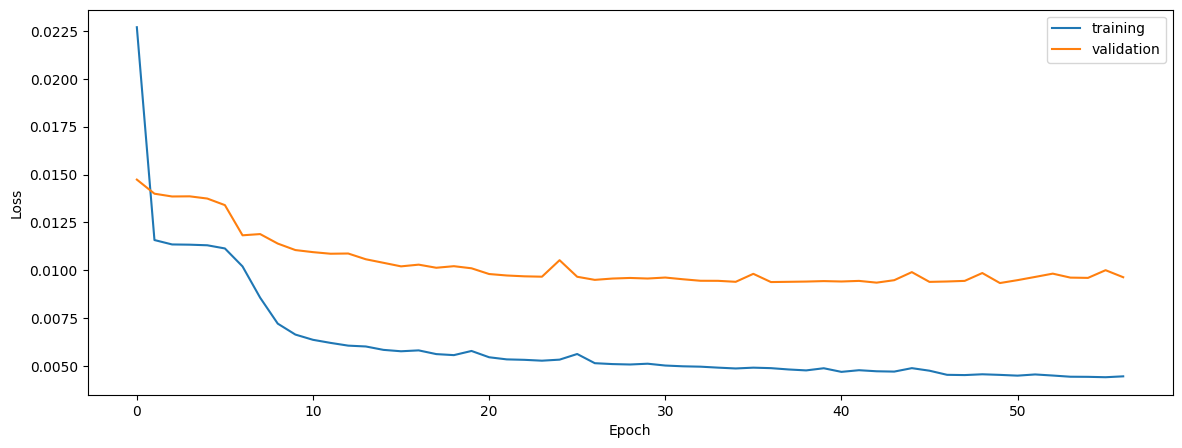

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7813338657442943
0.5857037010880324
0.6634020774396314


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7813338657442943
0.5857037010880324
0.6634020774396314


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7991808845740586
0.6216940892511105
0.7062913646538501


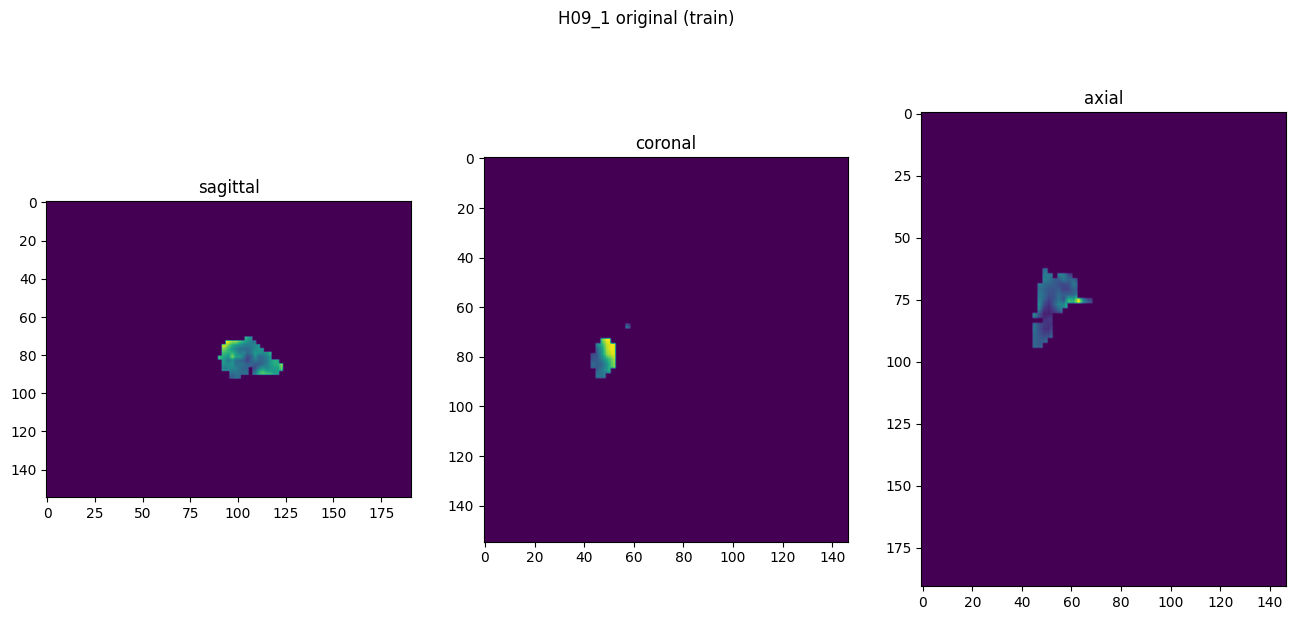

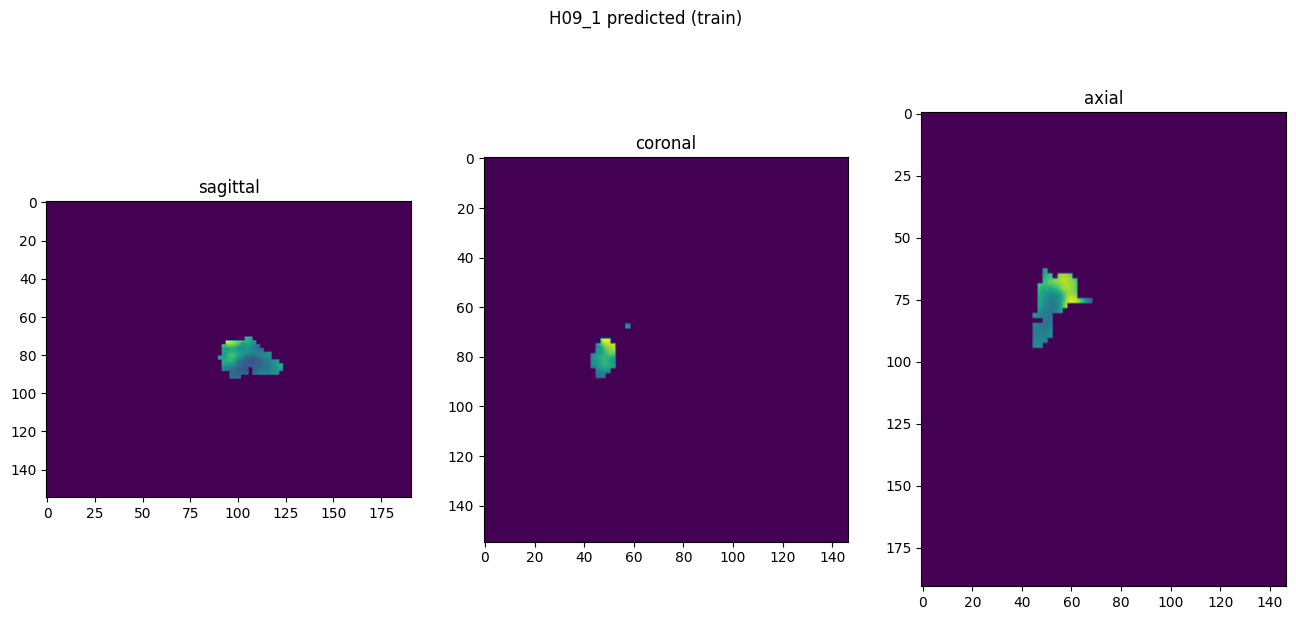

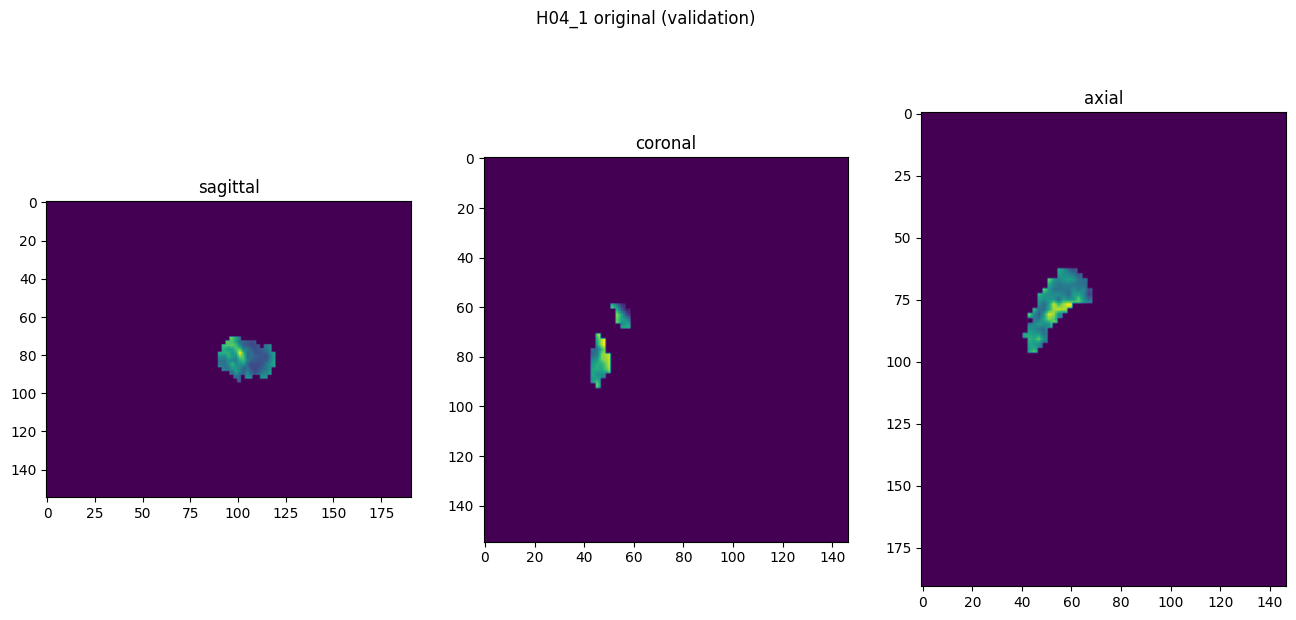

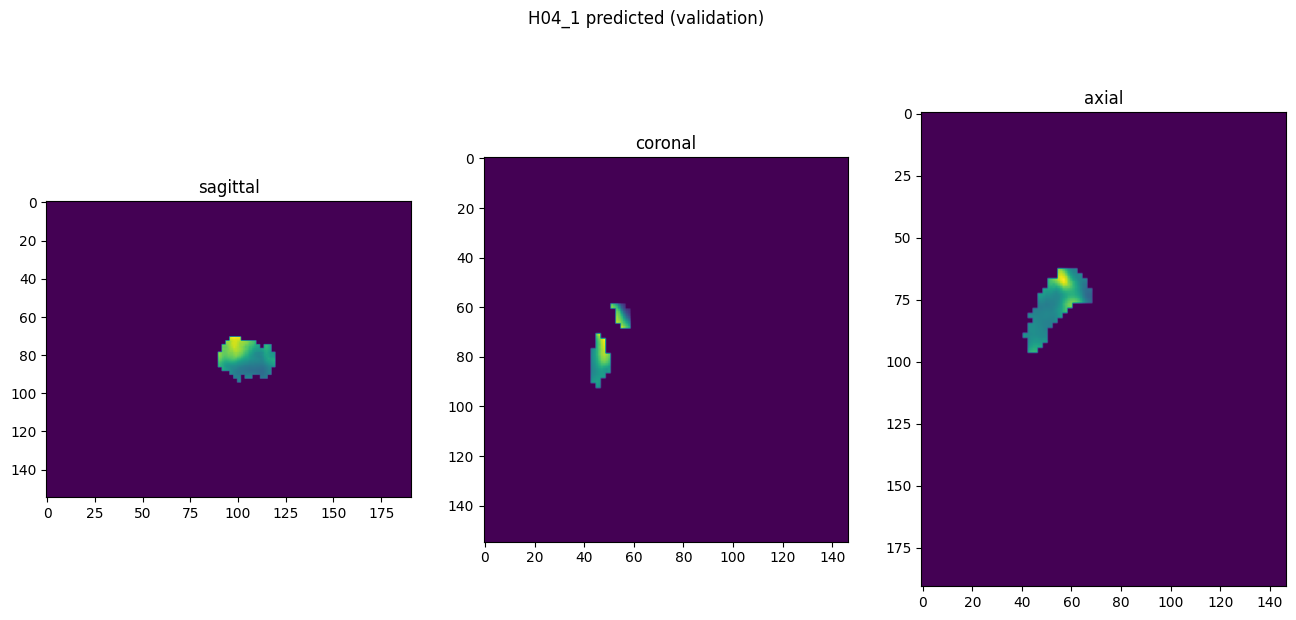

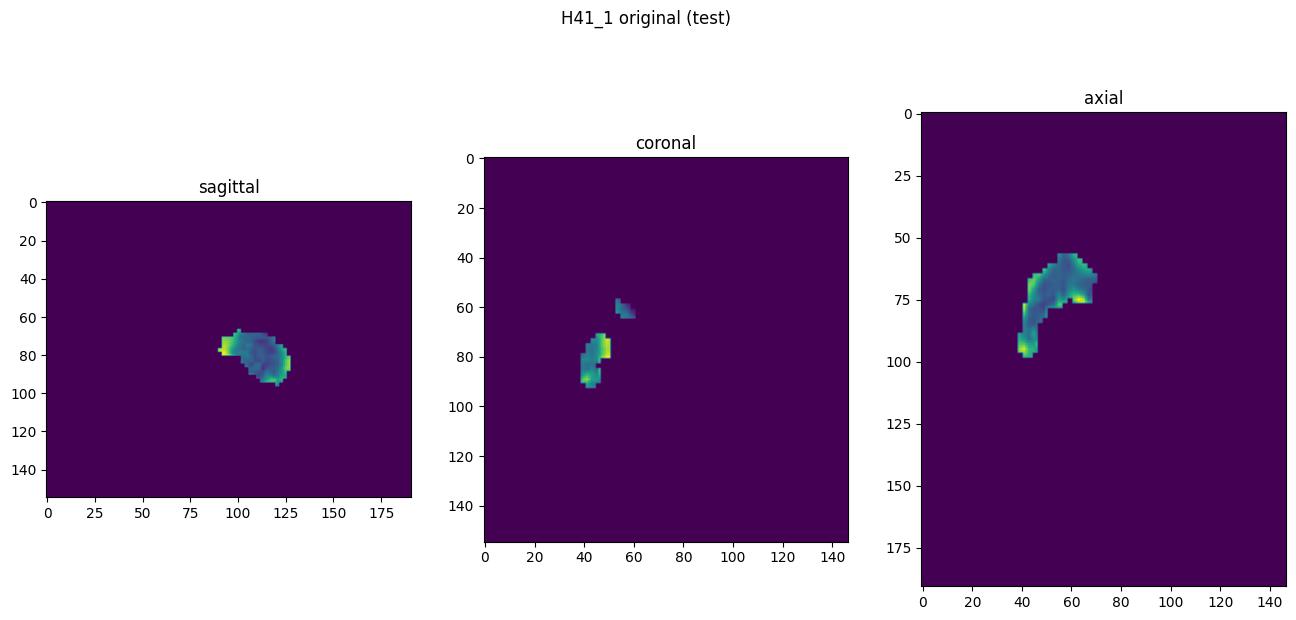

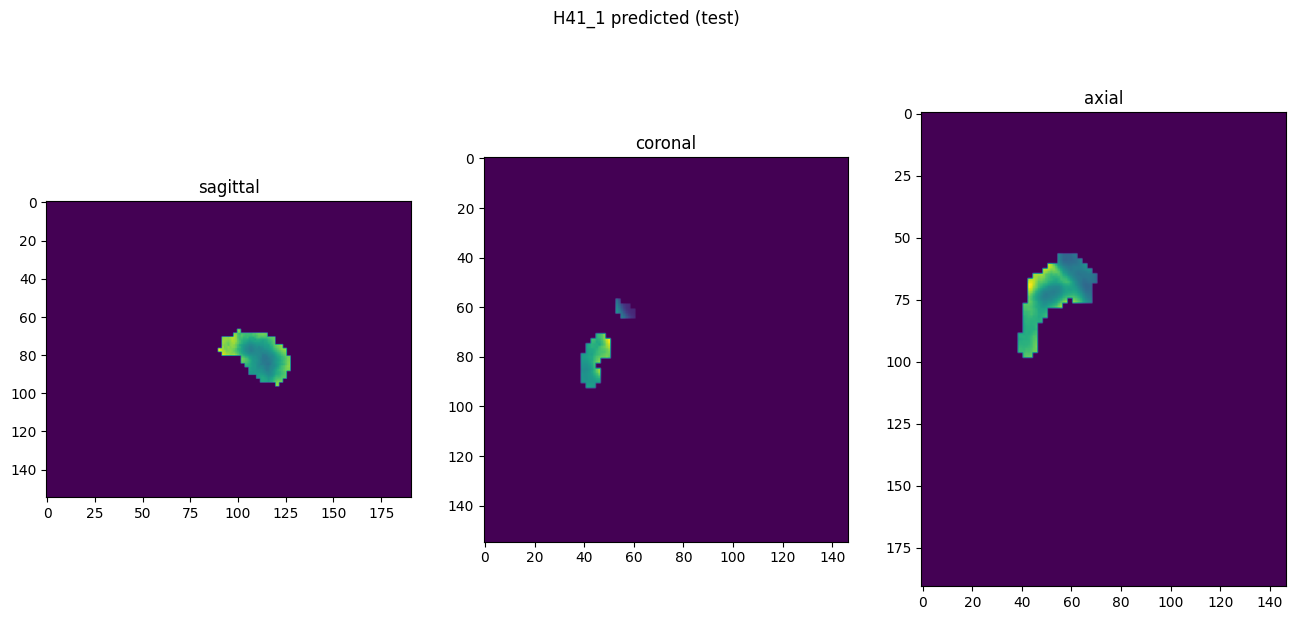

In [10]:
showResults(model, gen, threshold=None, background=False)